# Analyzing data science articles

This notebook recreate the study present [here](https://medium.com/the-mission/this-new-data-will-make-you-rethink-how-you-write-headlines-751358f6639a) focusing in data science articles. 

The data for this notebook can be found [here](https://www.kaggle.com/viniciuslambert/medium-data-science-articles-dataset).


## Possible questions:

- What is the influence of headlines in popularity?
- Does reading time influence in popularity?
- does the author matter?
- there was a better day to post?


## CRISP-DM

- Business Undestanding
- Data Undestanding
- Prepare Data
- Model Data
- Result 
- Deploy

In [1]:
import numpy as np
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', None)

df = pd.read_csv('medium-data-science-articles-2020.csv')


print(df.shape)
df.head()

(108021, 10)


,url,title,author,author_page,subtitle,claps,responses,reading_time,tag,date
0,https://towardsdatascience.com/making-python-programs-blazingly-fast-c1cd79bd1b32,Making Python Programs Blazingly Fast,martin.heinz,https://towardsdatascience.com/@martin.heinz,Let’s look at the performance of our Python programs and see how…,3300.0,3,5,Data Science,2020-01-01
1,https://towardsdatascience.com/how-to-be-fancy-with-python-8e4c53f47789,How to be fancy with Python,dipam44,https://towardsdatascience.com/@dipam44,Python tricks that will make your life easier,1700.0,12,5,Data Science,2020-01-01
2,https://uxdesign.cc/how-exactly-do-you-find-insights-from-qualitative-user-research-603bcafbc8b3,How exactly do you find insights from qualitative user research?,taylornguyen144,https://uxdesign.cc/@taylornguyen144,Visualizing the synthesis processes…,1100.0,3,4,Data Science,2020-01-01
3,https://towardsdatascience.com/from-scratch-to-search-playing-with-your-data-elasticsearch-ingest-pipelines-6d054bf5d866,From scratch to search: playing with your data (Elasticsearch Ingest Pipelines),stanislavprihoda,https://towardsdatascience.com/@stanislavprihoda,One Pipeline to rule…,232.0,1,9,Data Science,2020-01-01
4,https://www.cantorsparadise.com/the-waiting-paradox-an-intro-to-probability-distributions-97c0aedb8c1,The Waiting Paradox: An Intro to Probability Distributions,maikeelisa,https://www.cantorsparadise.com/@maikeelisa,How much longer do I have to wait for my…,859.0,5,8,Data Science,2020-01-01


## Find url duplicateds values and drop it

In [2]:
print(f' We have {df.url.duplicated().sum()} duplicated values in url colum')
df.shape
#df[df.url.duplicated(keep=False)]

 We have 50 duplicated values in url colum


(108021, 10)

In [3]:
# I analysed the values and conclude that the correct duplicated values 
#is aways the first! So let's keep it.

df = df.drop_duplicates(subset=['url'], keep='first')
print(f' We have {df.url.duplicated().sum()} duplicated values in url colum')
df.shape

 We have 0 duplicated values in url colum


(107971, 10)

## Get most popular set of words in titles

### Data understanding

In [4]:
#df.title[:30]

### Cleaning the data

As you can see, it has some confusing character, so we need to normalize the data.

In [5]:
def normalize_title(title):
    title = unicodedata.normalize("NFKD", title) # normalize data
    title = re.sub('<[^>]+>', '', title) # remove anything beteween <> (html noise)
    title = re.sub(" \d+", r" X", title) # replace numbers by X 
    return title 
    
df.title = df.title.apply(normalize_title)
df.title[:10]

0                                              Making Python Programs Blazingly Fast
1                                                        How to be fancy with Python
2                   How exactly do you find insights from qualitative user research?
3    From scratch to search: playing with your data (Elasticsearch Ingest Pipelines)
4                         The Waiting Paradox: An Intro to Probability Distributions
5                                 Sentiment Analysis of Movie Reviews in NLTK Python
6                               How to Write Scripts That Check Data Quality For You
7                      Gradient Based Optimizations: Jacobians, Jababians & Hessians
8                     [Time Series Forecast] Anomaly detection with Facebook Prophet
9                                                         Decision Trees for Dummies
Name: title, dtype: object

## Get data insights
### What is the most popular set of words?

In [6]:
words_count = {}

for title in df.title:
    splited_title = title.split(' ')
    if len(splited_title) > 2:
        for i in range((len(splited_title) - 2)):
            word_group = f'{splited_title[i]} {splited_title[i+1]} {splited_title[i+2]}'
            if word_group in words_count.keys():
                words_count[word_group] += 1 # apeear one more time
            else:
                words_count[word_group] = 1 # appear for the first time

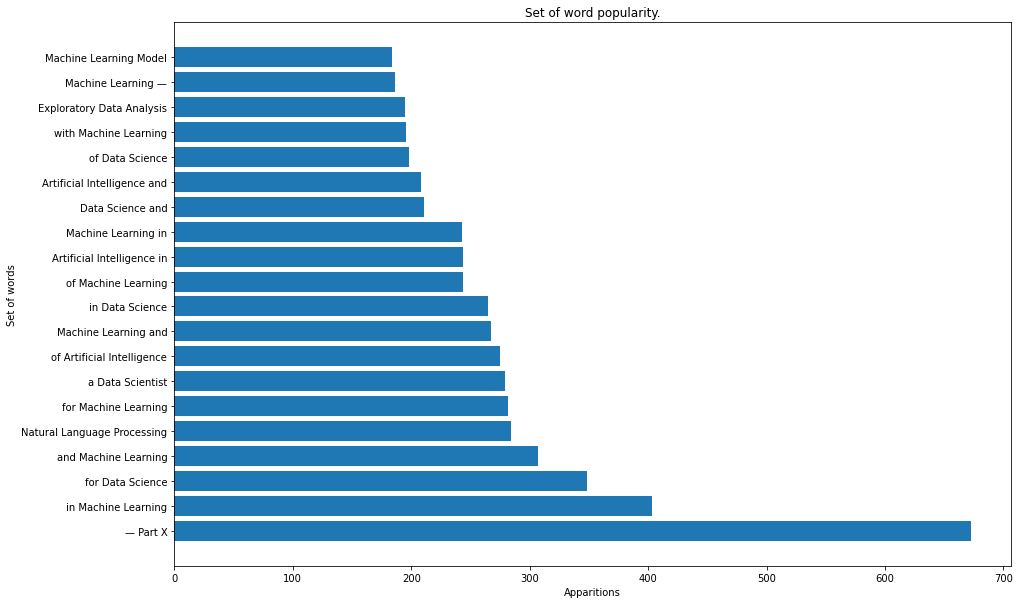

In [7]:
sorted_word_counts = pd.DataFrame(sorted(words_count.items(), key=lambda x: x[1], reverse=True), 
                                  columns=['word_set', 'apparitions'])

plt.figure(figsize=(15, 10))
plt.barh(sorted_word_counts.word_set[:20],sorted_word_counts.apparitions[:20])
plt.title('Set of word popularity.')
plt.xlabel('Apparitions')
plt.ylabel('Set of words')
plt.show()

### What headline set of words atract mo claps?

In [8]:
claps_for_set_of_words = {}

for title, claps in zip(df.title, df.claps):
    splited_title = title.split(' ')
    if len(splited_title) > 2:
        for i in range((len(splited_title) - 2)):
            word_group = f'{splited_title[i]} {splited_title[i+1]} {splited_title[i+2]}'
            if word_group in claps_for_set_of_words.keys():
                claps_for_set_of_words[word_group]['count'] += 1
                claps_for_set_of_words[word_group]['total_claps'] += claps
            else:
                claps_for_set_of_words[word_group] = {'count' : 1, 
                                                      'total_claps': claps}
                

claps_for_set_of_words            

{'Making Python Programs': {'count': 1, 'total_claps': 3300.0},
 'Python Programs Blazingly': {'count': 1, 'total_claps': 3300.0},
 'Programs Blazingly Fast': {'count': 1, 'total_claps': 3300.0},
 'How to be': {'count': 33, 'total_claps': 5831.0},
 'to be fancy': {'count': 2, 'total_claps': 2673.0},
 'be fancy with': {'count': 2, 'total_claps': 2673.0},
 'fancy with Python': {'count': 1, 'total_claps': 1700.0},
 'How exactly do': {'count': 1, 'total_claps': 1100.0},
 'exactly do you': {'count': 1, 'total_claps': 1100.0},
 'do you find': {'count': 1, 'total_claps': 1100.0},
 'you find insights': {'count': 1, 'total_claps': 1100.0},
 'find insights from': {'count': 1, 'total_claps': 1100.0},
 'insights from qualitative': {'count': 1, 'total_claps': 1100.0},
 'from qualitative user': {'count': 1, 'total_claps': 1100.0},
 'qualitative user research?': {'count': 1, 'total_claps': 1100.0},
 'From scratch to': {'count': 1, 'total_claps': 232.0},
 'scratch to search:': {'count': 1, 'total_clap

In [9]:
# Get only the popular set words, the one with more than X aparitions
X = 50
claps_for_set_of_words = {key:val for key, val in claps_for_set_of_words.items() if val['count'] >= X}


print(f' There are {len(claps_for_set_of_words)} set of words that appear more than {X} times')

 There are 183 set of words that appear more than 50 times


In [10]:
# Extrac the mean value of the set of words.
for key in claps_for_set_of_words.keys():
    claps_for_set_of_words[key]['claps_mean'] = claps_for_set_of_words[key]['total_claps'] / claps_for_set_of_words[key]['count']
           
#claps_for_set_of_words

In [11]:
transform_from_dict = [] # Auxiliar list to create a DataFrame

for x in claps_for_set_of_words:
    claps_for_set_of_words[x]['word_set'] = x
    transform_from_dict.append(claps_for_set_of_words[x])

transform_from_dict = sorted(transform_from_dict, key=lambda x: x['claps_mean'], reverse=True)

df_claps = pd.DataFrame.from_dict(
                transform_from_dict,
                orient='columns',
                dtype=None
)


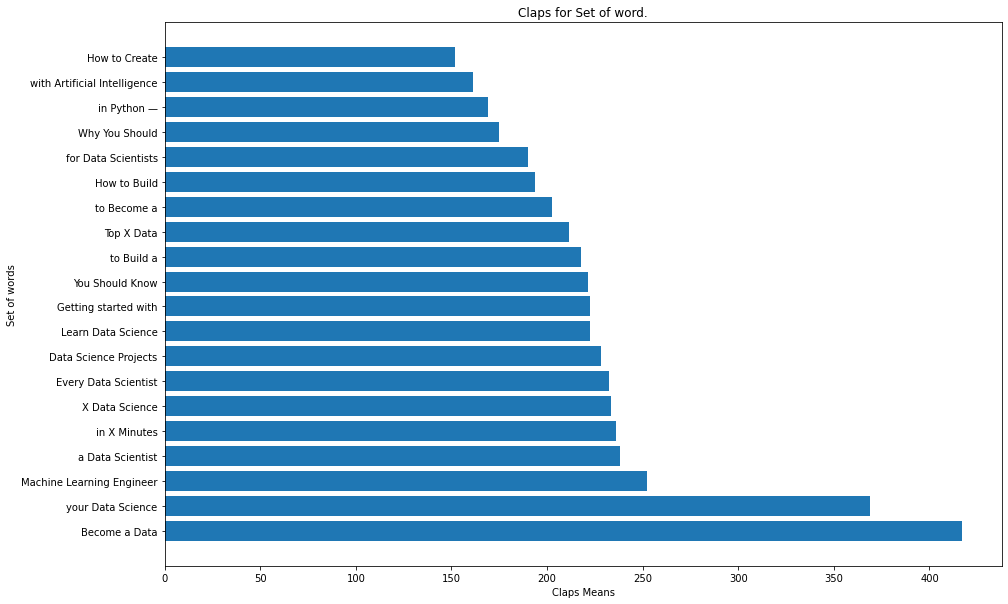

In [12]:
plt.figure(figsize=(15, 10))
plt.barh(df_claps.word_set[:20],df_claps.claps_mean[:20])
plt.title('Claps for Set of word.')
plt.xlabel('Claps Means')
plt.ylabel('Set of words')
plt.show()

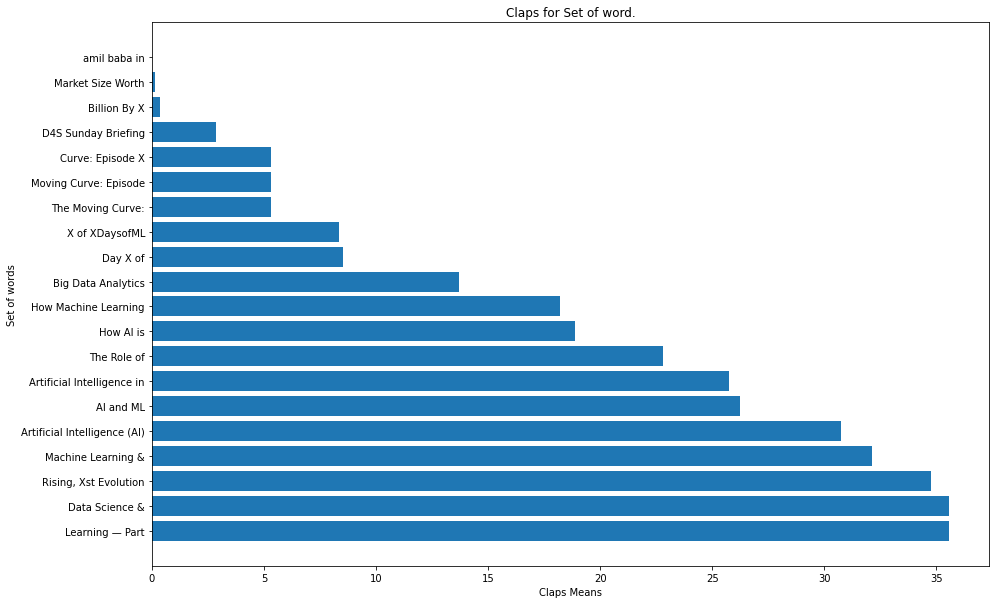

In [13]:
plt.figure(figsize=(15, 10))
plt.barh(df_claps.word_set[-20:],df_claps.claps_mean[-20:])
plt.title('Claps for Set of word.')
plt.xlabel('Claps Means')
plt.ylabel('Set of words')
plt.show()